# Demonstration of linear Kalman filter


This notebook demonstrates the use of a linear Kalman filter to recover the underling state evolution of a pulsar frequency timeseries.

It also discusses the use of likelihood methods for parameter estimation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
try:
    sys.path.remove("../py_src") # Hacky way to add higher directory to python modules path. 
except:
    pass
sys.path.append("../py_src") # Means that I dont have to make src/ a proper python package

## 1. Single run example - true parameters


We can generate some synthetic data, and run the Kalman filter to see how well we recover the state.

The Kalman filter depends on a series of physical parameters (e.g. GW angular frequency). 

Lets assume we know these perfectly, and see how the filter does.

In [3]:
from system_parameters import SystemParameters
from pulsars import Pulsars
from gravitational_waves import GWs
from synthetic_data import SyntheticData
from plotting import plot_statespace,plot_all
from model import LinearModel
from kalman_filter import KalmanFilter
from bilby_wrapper import BilbySampler
from priors import priors_dict,bilby_priors_dict

In [26]:
P   = SystemParameters()       # define the system parameters as a class
PTA = Pulsars(P)               # setup the PTA
GW  = GWs(P)                   # setup GW related constants and functions. This is a dict, not a class, for interaction later with Bilby 
data = SyntheticData(PTA,GW,1) # generate some synthetic data


#Define the model 
model = LinearModel

#Initialise the Kalman filter
KF = KalmanFilter(model,data.f_measured,PTA)

# Run the KF once with the correct parameters
true_parameters = priors_dict(PTA,GW)
import timeit
timeit.timeit(KF.likelihood(true_parameters,"H1"))
# print("Model likelihood is: ", model_likelihood)
# plot_all(PTA.t,data.intrinsic_frequency,data.f_measured,model_state_predictions,psr_index =0)

The number of pulsars is:
1


ValueError: stmt is neither a string nor callable

Cool! This works well. The predicted state and the true state are perfectly overlaid.



## 2. Single run example - wrong parameters


Now lets do the same thing again, but this time with the wrong parameters.

Lets just change $\omega$ from its true value of $1 \times 10^{-7}$ Hz to $1 \times 10^{-8}$ Hz.


Final prediction:  329.1692862689631
Final measurement:  328.6023016409426


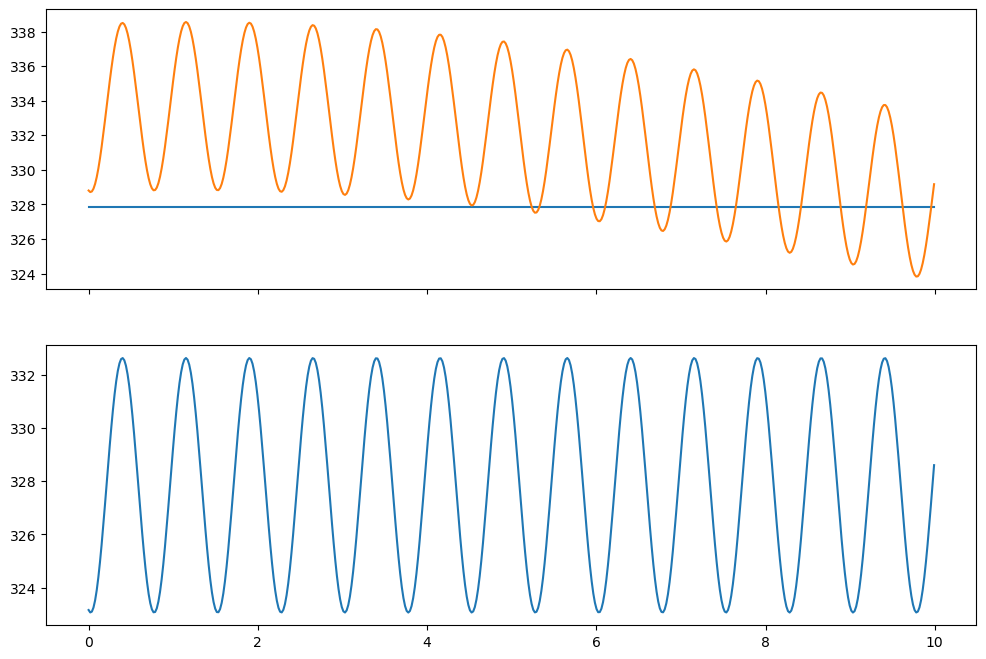

In [6]:
wrong_parameters = true_parameters.copy()
wrong_parameters["omega_gw"] = 1e-8 #modify the omega value to the wrong value
model_likelihood,model_state_predictions,model_covariance = KF.likelihood(wrong_parameters,"H1")
plot_all(PTA.t,data.intrinsic_frequency,data.f_measured,model_state_predictions,psr_index =0)

Now the Kalman filter does a bad job. This is of course expected behaviour.


## 3. Likelihood methods


When we do parameter estimation using either (a) Nested sampling (c.f. Bilby) or (b) expectation maximisation we want to try to maximise the likelihood.

When we run the Kalman filter for a particular set of parameters it returns a likelihood $\mathcal{L}(\hat{\theta}) = \text{KF}(\hat{\theta})$ 

For now, lets consider a simple case and suppose we know all of the parameters exactly, apart from $\omega$.

What does $\mathcal{L}(\omega)$ look like?

In [10]:
import numpy as np
from plotting import plot_likelihood
N = 2 #number of samples
omegas = np.logspace(-8,-6,N) #consider omegas from 1e-8 to 1e-6
likelihoods = np.zeros(N)

for i in range(N):
    print(i)
    guessed_parameters = true_parameters.copy()
    guessed_parameters["omega_gw"] = omegas[i]
    model_likelihood,model_state_predictions,model_covariance = KF.likelihood(guessed_parameters,"H1")

    likelihoods[i] = model_likelihood



0
1


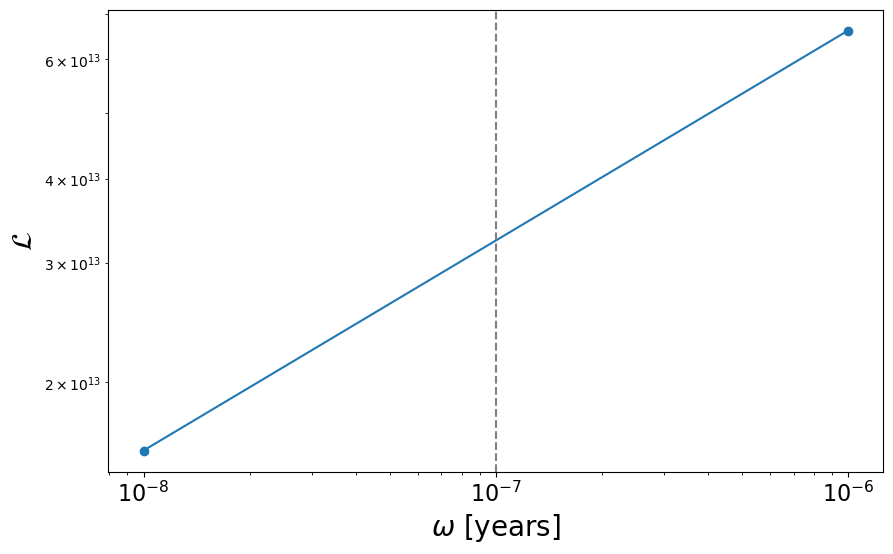

In [11]:
plot_likelihood(omegas,likelihoods)

The likelihood does decrease near the true value of $\omega$, but the range is quite narrow.

We can look at this in more detail close to $\omega = 1 \times 10^{-7}$ Hz.


In [22]:
narrow_omegas=np.arange(4e-7, 6e-7,1e-8) #narrow range with a fixed separation
narrow_likelihoods = np.zeros(len(narrow_omegas))


for i in range(len(narrow_omegas)):
    print(i)
    guessed_parameters = true_parameters.copy()
    guessed_parameters["omega_gw"] = narrow_omegas[i]
    model_likelihood,model_state_predictions,model_covariance = KF.likelihood(guessed_parameters, "H1")

    narrow_likelihoods[i] = model_likelihood

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [23]:
narrow_likelihoods

array([-3.13545614e+13, -2.40043906e+13, -2.49830929e+13, -2.92764490e+13,
       -2.38110343e+13, -2.87877630e+13, -2.36548969e+13, -3.33776301e+13,
       -2.74468021e+13, -3.65472599e+13,  2.65258460e+05, -3.42259791e+13,
       -2.54055577e+13, -3.66156171e+13, -2.64756117e+13, -4.29604196e+13,
       -2.83121409e+13, -4.79028929e+13, -3.80763043e+13, -4.71440458e+13])

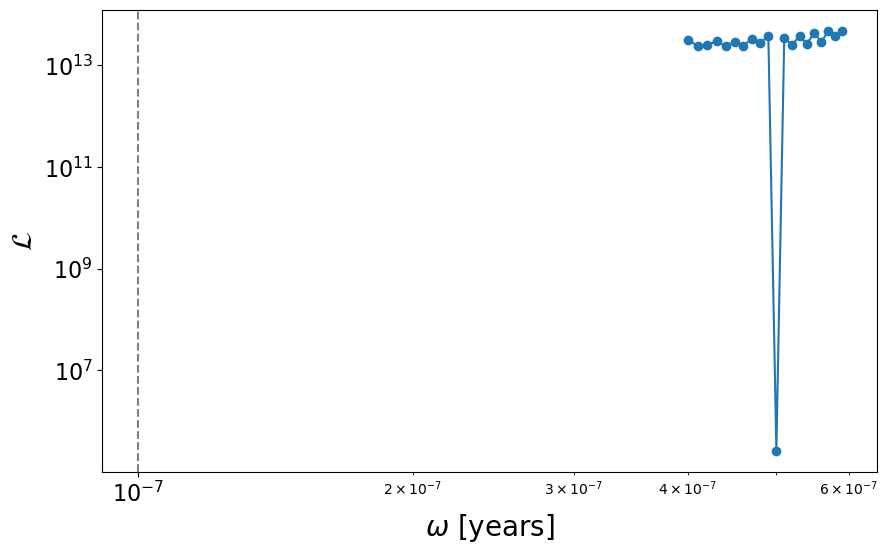

In [24]:
plot_likelihood(narrow_omegas,narrow_likelihoods)